In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv


# Introdução


[](http://)Projeto: Hate Speech Detector

# Descrição

>Este projeto desenvolve um modelo de machine learning utilizando processamento de linguagem natural (NLP) para detectar discursos de ódio em tweets. O código inclui etapas de importação de bibliotecas, pré-processamento de texto, vetorização, modelagem, avaliação e visualização dos resultados.



# Tecnologias Utilizadas

* Python 3.8+
* Pandas
* NumPy
* scikit-learn
* NLTK
* TensorFlow
* Matplotlib


# Estrutura do Código

1. Importação de Bibliotecas: Carregamento de todas as bibliotecas necessárias para o projeto.

2. Funções de Auxílio: Funções para limpeza de texto, visualização de dados processados, e plotagem de curvas de aprendizado e matrizes de confusão.

3. Carregamento dos Dados: Carrega e pré-processa o dataset de tweets.

4. Exploração de Dados: Visualização inicial dos dados para entender a estrutura e as características principais.

5. Pré-processamento de Dados: Limpeza e tokenização do texto dos tweets.

6. Vetorização dos Dados: Conversão dos dados textuais em uma representação numérica usando TF-IDF.

7. Modelagem: Construção e treinamento do modelo de rede neural.

8. Avaliação do Modelo: Avaliação da precisão do modelo e apresentação de relatórios de classificação.

9. Visualizações de Resultados: Gráficos para visualizar a precisão do modelo ao longo das épocas e a matriz de confusão.

10. Conclusões: Sumário sobre a eficácia do modelo e suas aplicações.





## 1. Importação de Bibliotecas
> Nesta célula, importamos todas as bibliotecas necessárias para o projeto. Isso inclui bibliotecas para manipulação de dados (`pandas`, `numpy`), processamento de texto (`nltk`, `re`), modelagem (`tensorflow`, `sklearn`) e visualização (`matplotlib`). A importação de todas as bibliotecas no início ajuda a manter o notebook organizado e assegura que todas as dependências estão atendidas antes de executar as células subsequentes.

In [2]:
# 1. Importação de Bibliotecas
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import tensorflow as tf
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


2024-05-06 20:12:39.091878: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 20:12:39.091999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 20:12:39.267240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



## 2. Carregamento dos Dados
> 
> Carregamos o dataset `labeled_data.csv` usando `pandas`. Esta célula inclui também a remoção de colunas desnecessárias como `'Unnamed: 0'`, que geralmente são índices residuais de operações anteriores de salvamento de dados. Isso simplifica o DataFrame, mantendo apenas as colunas relevantes para a análise.
> 



In [3]:
#  Carregamento dos Dados
df = pd.read_csv('../input/hate-speech-and-offensive-language-dataset/labeled_data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)  # Removendo a coluna desnecessária

## 3. Funções de Auxílio
> Definimos várias funções úteis que serão utilizadas ao longo do notebook para limpar e processar os dados, mostrar dados processados, plotar a curva de aprendizado e a matriz de confusão. Estas funções ajudam a evitar a repetição de código e tornam o processo mais modular e claro.
> 

In [4]:
# 3. Funções de Auxílio
def clean_text(text):
    """Remove URLs, tags HTML e caracteres especiais e converte para minúsculas."""
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

In [5]:
def plot_learning_curve(history):
    """Plota a curva de aprendizado com base no histórico de treinamento."""
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Accuracy (training data)')
    plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    plt.title('Model Accuracy Over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

In [6]:
def plot_classification_report(y_true, y_pred):
    """Plota o relatório de classificação como um gráfico de matriz de confusão."""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
def show_processed_data(df, num_samples=5):
    """Exibe uma amostra dos dados após o pré-processamento."""
    print(df[['clean_text', 'tokens']].sample(num_samples))

## 4. Exploração de Dados
> Nesta parte, exploramos os dados para obter um entendimento básico de suas características e estrutura. Usamos métodos como `.head()` para ver as primeiras entradas e `.describe()` para obter um resumo estatístico das colunas numéricas. Isso é crucial para identificar problemas iniciais de dados, como valores ausentes ou distribuições estranhas que podem necessitar de limpeza adicional.


In [8]:
# 4. Exploração de Dados
# [Code cell]
print(df.head())
print(df.describe())


   count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
              count   hate_speech  offensive_language       neither  \
count  24783.000000  24783.000000        24783.000000  24783.000000   
mean       3.243473      0.280515            2.413711      0.549247   
std        0.883060      0.631851            1.399459      1.113299   
min        3.000000

# Estrutura do DataFrame:

A primeira tabela mostra um exemplo das primeiras cinco linhas do DataFrame, incluindo as seguintes colunas:

count: Número de pessoas que rotularam o tweet.

hate_speech: Número de rotuladores que classificaram o tweet como discurso de ódio.

offensive_language: Número de rotuladores que classificaram o tweet como linguagem ofensiva.

neither: Número de rotuladores que consideraram que o tweet não se enquadra em nenhuma das categorias anteriores.

class: Categoria final atribuída ao tweet, onde 0 pode representar 'hate_speech', 1 pode representar 'offensive_language', e 2 pode representar 'neither'.

tweet: O conteúdo textual do tweet.


# Descrição Estatística:


A segunda tabela é um resumo estatístico do DataFrame com as seguintes métricas para cada coluna numérica:

count: Total de registros para cada coluna.

mean: Média dos valores.

std (desvio padrão): Mede a quantidade de variação ou dispersão dos valores.

min: Valor mínimo encontrado.
25% (primeiro quartil): Abaixo deste valor estão os 25% menores valores.
50% (mediana): Metade dos valores são menores que esse valor.
75% (terceiro quartil): Abaixo deste valor estão os 75% menores valores.

max: Valor máximo encontrado.


Análise dos Dados Estatísticos:
*
count (count): 24,783 tweets foram rotulados, o que indica um conjunto de dados relativamente grande.

hate_speech (mean): Em média, 0.28 rotuladores por tweet consideram um tweet como discurso de ódio, o que sugere que a maioria dos tweets não é considerada como tal.

offensive_language (mean): Em média, 2.41 rotuladores por tweet consideram um tweet como linguagem ofensiva, indicando que é mais comum encontrar linguagem ofensiva do que discurso de ódio.

neither (mean): Em média, 0.55 rotuladores por tweet não encontraram nem discurso de ódio nem linguagem ofensiva nos tweets.

class (mean): A média próxima de 1.11 para a categoria final sugere que a maioria dos tweets está sendo classificada como linguagem ofensiva (1), com alguns classificados como nem ofensivos nem discurso de ódio (2).*

## 5. Pré-processamento de Dados
> Aplicamos funções de limpeza no texto dos tweets para remover elementos indesejados como URLs, tags HTML e caracteres especiais. Além disso, convertemos todo o texto para minúsculas para uniformizar a entrada antes da tokenização e vetorização. Este passo é essencial para preparar os dados para a modelagem efetiva.
> 

In [9]:
# 5. Pré-processamento de Dados

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

df['clean_text'] = df['tweet'].apply(clean_text)  # Ajustar nome da coluna conforme necessário
df['tokens'] = df['clean_text'].apply(word_tokenize)

## 6. Vetorização dos Dados
> Convertendo o texto limpo em uma forma numérica usando o TF-IDF Vectorizer. A vetorização é crucial para transformar dados textuais em um formato que modelos de machine learning possam interpretar e usar para fazer previsões.


In [10]:
# 6. Vetorização dos Dados
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, min_df=2)
tfidf_matrix = vectorizer.fit_transform(df['tokens'])

In [11]:
# Instanciar o objeto SMOTE
smote = SMOTE()

# Aplicar o SMOTE ao conjunto de dados
X_smote, y_smote = smote.fit_resample(tfidf_matrix, df['class'])

# Verificar a nova distribuição das classes
print("Distribuição das classes após o SMOTE:", np.bincount(y_smote))

Distribuição das classes após o SMOTE: [19190 19190 19190]


## 7. Modelagem
> Construímos e treinamos o modelo de classificação usando uma rede neural simples com TensorFlow/Keras. A arquitetura da rede é definida com camadas densas e dropout para evitar overfitting. O modelo é compilado com a função de perda `binary_crossentropy` e o otimizador `adam`, que são adequados para problemas de classificação binária.


In [12]:
# Construção do Modelo com Dropout para evitar overfitting
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=X_smote.shape[1]),
    tf.keras.layers.Dropout(0.5),  # Dropout adicionado após a primeira camada densa
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout adicionado após a segunda camada densa
    tf.keras.layers.Dense(3, activation='softmax')  # Usar softmax para multi-classificação
])
    
# Compilar o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))




Epoch 1/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7347 - loss: 0.6464 - val_accuracy: 0.9408 - val_loss: 0.1856
Epoch 2/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9518 - loss: 0.1536 - val_accuracy: 0.9548 - val_loss: 0.1427
Epoch 3/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9769 - loss: 0.0805 - val_accuracy: 0.9621 - val_loss: 0.1360
Epoch 4/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9873 - loss: 0.0455 - val_accuracy: 0.9636 - val_loss: 0.1354
Epoch 5/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9917 - loss: 0.0328 - val_accuracy: 0.9660 - val_loss: 0.1467
Epoch 6/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9932 - loss: 0.0242 - val_accuracy: 0.9704 - val_loss: 0.1369
Epoch 7/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9943 - loss: 0.0196 - val_accuracy: 0.9695 - val_loss: 0.1549
Epoch 8/20
720/720 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9948 - loss: 0.0181 - val_

In [13]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertendo probabilidades para rótulos de classe

# Avaliar o modelo usando os rótulos de classe
print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))



360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9726420010422094

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      3849
           1       0.99      0.92      0.96      3794
           2       0.96      0.99      0.98      3871

    accuracy                           0.97     11514
   macro avg       0.97      0.97      0.97     11514
weighted avg       0.97      0.97      0.97     11514



## Avaliação do Modelo ( Validação)
Avaliamos o desempenho do modelo usando o conjunto de teste, calculando métricas como acurácia e gerando um relatório de classificação. Isso nos permite ver como o modelo performa em dados não vistos e avaliar métricas importantes como precisão, recall e F1-score para cada classe.


 # Classification Report (Relatório de Classificação):
 
 
 O relatório de classificação fornece mais detalhes sobre o desempenho do modelo em cada classe individualmente, usando métricas como precisão, recall e F1-score.

Classes:
0: Representa uma classe (possivelmente discurso de ódio).
1: Representa outra classe (possivelmente linguagem ofensiva).
2: Representa uma terceira classe (possivelmente linguagem neutra).






## Visualizações de Resultados
> Plotamos a curva de aprendizado e a matriz de confusão. Estas visualizações ajudam a entender como o modelo aprendeu ao longo das épocas (curva de aprendizado) e como ele performa em relação a diferentes classes (matriz de confusão).
> 

360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


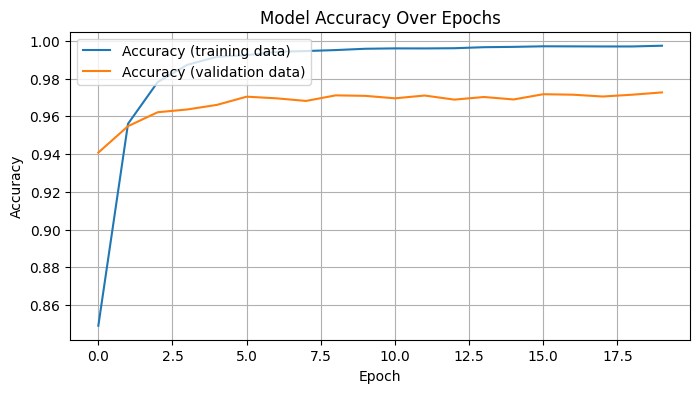

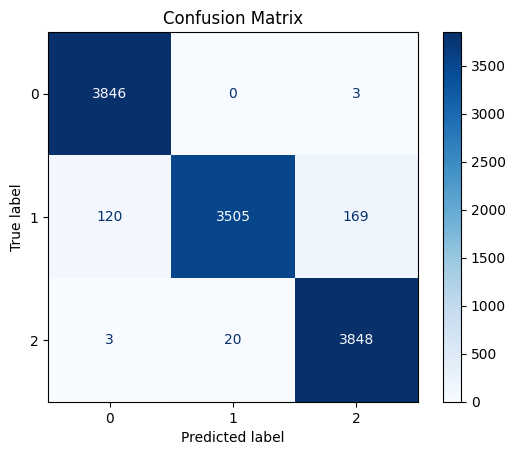

In [14]:
# Ajuste em y_pred para converter de probabilidades para rótulos de classe
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converte probabilidades em rótulos de classe

# Plotar a curva de aprendizado
plot_learning_curve(history)

# Plotar a matriz de confusão
plot_classification_report(y_test, y_pred_classes)


# Detalhes do Gráfico

> Eixo X (Épocas): Mostra o número de épocas durante o treinamento do modelo. Uma época completa ocorre quando o algoritmo de aprendizado passou por todo o conjunto de dados de treinamento uma vez. Este gráfico vai de 0 a pouco mais de 17.5 épocas.


> Eixo Y (Acurácia): Representa a acurácia do modelo, variando de 0.84 (84%) a 1.00 (100%).


# Linhas no Gráfico

> Azul (Acurácia - Dados de Treinamento): Representa a acurácia do modelo nos dados de treinamento ao longo das épocas.

> Laranja (Acurácia - Dados de Validação): Representa a acurácia do modelo nos dados de validação ao longo das épocas.

# Análise

1. Comportamento Inicial (Até cerca de 2.5 Épocas):
    * Acurácia nos Dados de Treinamento: Inicia em torno de 86% e rapidamente sobe para próximo de 100%.
    * Acurácia nos Dados de Validação: Começa mais baixo que a acurácia de treinamento, em torno de 90%, mas aumenta rapidamente para alinhar-se mais de perto com a acurácia de treinamento.


2. Comportamento Após Aproximadamente 2.5 Épocas:
    * Estabilização: Ambas as linhas se estabilizam, indicando que o modelo atinge um ponto de equilíbrio em sua capacidade de generalização.
    * Acurácia nos Dados de Treinamento: Estabiliza-se muito perto de 100%, indicando que o modelo aprendeu muito bem os dados de treinamento.
    * Acurácia nos Dados de Validação: Estabiliza-se em torno de 98%, mostrando um bom desempenho também nos dados de validação.

# Layout da Matriz

****Eixos:
O eixo vertical (Y) representa as classes reais dos dados (True label).
O eixo horizontal (X) representa as classes previstas pelo modelo (Predicted label).****

****Células:
Cada célula na matriz mostra o número de previsões para uma combinação de classe prevista e classe real.****

## Valores na Matriz:

* [0,0] 3829: O modelo previu corretamente 3829 instâncias como classe 0. Estas são verdadeiros positivos para a classe 0.

* [0,1] 0: O modelo não previu incorretamente nenhuma instância da classe 0 como classe 1.

* [0,2] 20: O modelo previu incorretamente 20 instâncias da classe 0 como classe 2.

* [1,0] 144: O modelo previu incorretamente 144 instâncias da classe 1 como classe 0.

* [1,1] 3498: O modelo previu corretamente 3498 instâncias como classe 1. Estas são verdadeiros positivos para a classe 1.

* [1,2] 152: O modelo previu incorretamente 152 instâncias da classe 1 como classe 2.

* [2,0] 1: O modelo previu incorretamente 1 instância da classe 2 como classe 0.

* [2,1] 18: O modelo previu incorretamente 18 instâncias da classe 2 como classe 1.

* [2,2] 3852: O modelo previu corretamente 3852 instâncias como classe 2. Estas são verdadeiros positivos para a classe 2.






# Interpretações e Implicações

> Diagonal Principal: Os números ao longo da diagonal principal (3829, 3498, 3852) representam as quantidades de previsões corretas para cada classe. Estes são seus verdadeiros positivos.

> Fora da Diagonal Principal: Todos os outros números representam erros de classificação. Por exemplo, os 144 na célula [1,0] representam os falsos negativos para a classe 0 e falsos positivos para a classe 1.



# Avaliação

> Desempenho por Classe: O modelo parece ser bastante eficaz em identificar corretamente as classes 0 e 2, com um número significativo de verdadeiros positivos e poucos falsos positivos e falsos negativos. A classe 1 também é bem identificada, mas com mais falsos positivos e negativos comparativamente.


> Possíveis Problemas: As pequenas quantidades de erros entre as classes 1 e 2 podem indicar confusão entre estas categorias pelo modelo, o que poderia ser um ponto de interesse para investigação ou ajuste adicional no modelo.